In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import to_categorical
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
import tensorflow as tf
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import f1_score
from keras.applications.inception_v3 import InceptionV3, preprocess_input

In [2]:
!pip install kaggle

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
! mkdir ~/.kaggle

In [7]:
! cp /content/drive/MyDrive/Kaggle_API/kaggle.json ~/.kaggle/

cp: cannot stat '/content/drive/MyDrive/Kaggle_API/kaggle.json': No such file or directory


In [8]:
! chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [5]:
! kaggle datasets download jessicali9530/celeba-dataset --force

Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other
100% 1.33G/1.33G [00:16<00:00, 91.3MB/s]
100% 1.33G/1.33G [00:16<00:00, 87.9MB/s]


In [6]:
! unzip celeba-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: img_align_celeba/img_align_celeba/197604.jpg  
  inflating: img_align_celeba/img_align_celeba/197605.jpg  
  inflating: img_align_celeba/img_align_celeba/197606.jpg  
  inflating: img_align_celeba/img_align_celeba/197607.jpg  
  inflating: img_align_celeba/img_align_celeba/197608.jpg  
  inflating: img_align_celeba/img_align_celeba/197609.jpg  
  inflating: img_align_celeba/img_align_celeba/197610.jpg  
  inflating: img_align_celeba/img_align_celeba/197611.jpg  
  inflating: img_align_celeba/img_align_celeba/197612.jpg  
  inflating: img_align_celeba/img_align_celeba/197613.jpg  
  inflating: img_align_celeba/img_align_celeba/197614.jpg  
  inflating: img_align_celeba/img_align_celeba/197615.jpg  
  inflating: img_align_celeba/img_align_celeba/197616.jpg  
  inflating: img_align_celeba/img_align_celeba/197617.jpg  
  inflating: img_align_celeba/img_align_celeba/197618.jpg  
  inflating: img_align_celeba/img_align_celeba/19

In [7]:
ATTRIBUTE_PATH = '/content/list_attr_celeba.csv'
attr_df = pd.read_csv(ATTRIBUTE_PATH, index_col='image_id')
attr_df.head()

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
image_id,,,,,,,,,,,,,,,,,,,,,
000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [8]:
attr_df.replace(to_replace=-1, value=0, inplace=True)
attr_df.head()

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
image_id,,,,,,,,,,,,,,,,,,,,,
000001.jpg,0,1,1,0,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
000002.jpg,0,0,0,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
000003.jpg,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
000004.jpg,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,1,1,0,1
000005.jpg,0,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1


In [13]:
# Attributes
print('Attributes:')
for i, j in enumerate(attr_df.columns):
    print('    {:02d}: {}'.format(i,j))

Attributes:
    00: 5_o_Clock_Shadow
    01: Arched_Eyebrows
    02: Attractive
    03: Bags_Under_Eyes
    04: Bald
    05: Bangs
    06: Big_Lips
    07: Big_Nose
    08: Black_Hair
    09: Blond_Hair
    10: Blurry
    11: Brown_Hair
    12: Bushy_Eyebrows
    13: Chubby
    14: Double_Chin
    15: Eyeglasses
    16: Goatee
    17: Gray_Hair
    18: Heavy_Makeup
    19: High_Cheekbones
    20: Male
    21: Mouth_Slightly_Open
    22: Mustache
    23: Narrow_Eyes
    24: No_Beard
    25: Oval_Face
    26: Pale_Skin
    27: Pointy_Nose
    28: Receding_Hairline
    29: Rosy_Cheeks
    30: Sideburns
    31: Smiling
    32: Straight_Hair
    33: Wavy_Hair
    34: Wearing_Earrings
    35: Wearing_Hat
    36: Wearing_Lipstick
    37: Wearing_Necklace
    38: Wearing_Necktie
    39: Young


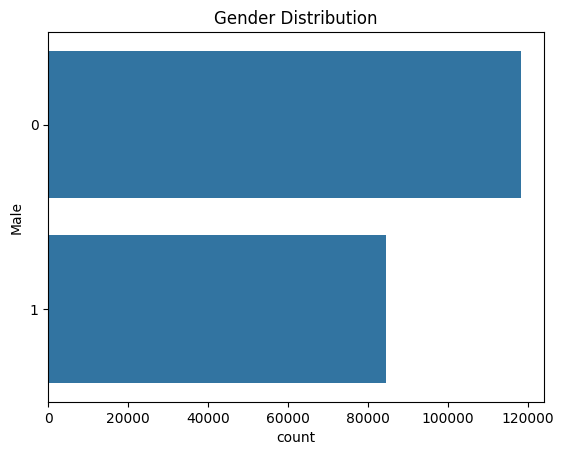

In [14]:
# Gender distribution
plt.title('Gender Distribution')
sns.countplot(y = 'Male', data=attr_df)
plt.show()

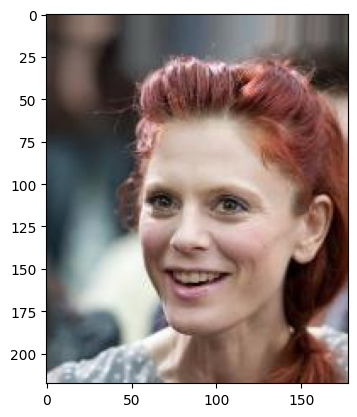

In [15]:
# Plotting an example image
img = load_img('/content/img_align_celeba/img_align_celeba/000002.jpg')
plt.imshow(img)
plt.show()

## Training, validation, testing split

In [9]:
# list_eval_partition.csv
parti_df = pd.read_csv('/content/list_eval_partition.csv', index_col='image_id')
parti_df.head()

,partition
image_id,
000001.jpg,0
000002.jpg,0
000003.jpg,0
000004.jpg,0
000005.jpg,0


In [10]:
parti_df.value_counts()

partition
0            162770
2             19962
1             19867
Name: count, dtype: int64

In [11]:
df = attr_df[['Male']].join(parti_df)
df.head()

,Male,partition
image_id,,
000001.jpg,0,0
000002.jpg,0,0
000003.jpg,1,0
000004.jpg,0,0
000005.jpg,0,0


In [12]:
IMG_WIDTH = 178
IMG_HEIGHT = 218

TRAINING_SAMPLES = 10000
VALIDATION_SAMPLES = 1000
TEST_SAMPLES = 1000

BATCH_SIZE = 32
NUM_EPOCHS = 50
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)

In [13]:
# Sampling
def load_reshape_img(filename):
    img = load_img(filename)
    img_array = img_to_array(img)/255
    img_array = img_array.reshape((1,) + img_array.shape)
    return img_array

def sampling(partition, sample_size, df):
    parti_mask = df['partition'] == partition
    male_mask = df['Male'] == 1
    female_mask = df['Male'] == 0
    sampled_df = pd.concat([
        df[parti_mask & male_mask].sample(sample_size//2),
        df[parti_mask & female_mask].sample(sample_size//2)
    ])

    if partition != 2:
        x = np.array([load_reshape_img('/content/img_align_celeba/img_align_celeba/' + filename) for filename in sampled_df.index])
        x = x.reshape(x.shape[0], IMG_HEIGHT, IMG_WIDTH, 3)
        y = to_categorical(sampled_df['Male'], 2)
    else:
        x = []
        y = []
        for index, target in sampled_df.iterrows():
            im = cv2.imread('/content/img_align_celeba/img_align_celeba/' + index) # return BGR
            im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (IMG_WIDTH, IMG_HEIGHT)).astype(np.float32) / 255.0 # convert it to RGB for consistency
            im = np.expand_dims(im, axis =0)
            x.append(im)
            y.append(target['Male'])

    return np.array(x).reshape(-1, IMG_HEIGHT, IMG_WIDTH, 3), np.array(y)

In [21]:
# Splitting
x_train, y_train = sampling(0, TRAINING_SAMPLES, df)
x_valid, y_valid = sampling(1, VALIDATION_SAMPLES, df)
x_test, y_test = sampling(2, TEST_SAMPLES, df)

In [22]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

train_datagen.fit(x_train)

train_generator = train_datagen.flow(x_train, y_train,batch_size=BATCH_SIZE)

In [23]:
print("Train set shape:", x_train.shape, y_train.shape)
print("Validation set shape:", x_valid.shape, y_valid.shape)
print("Test set shape:", x_test.shape, y_test.shape)

Train set shape: (10000, 218, 178, 3) (10000, 2)
Validation set shape: (1000, 218, 178, 3) (1000, 2)
Test set shape: (1000, 218, 178, 3) (1000,)


In [24]:
def create_model(input_shape):
    model = Sequential([
        Conv2D(16, (3,3), input_shape=input_shape, activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2)),

        Conv2D(32, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2)),

        Conv2D(64, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2)),
        Dropout(rate=0.4),

        Conv2D(64, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2)),
        Dropout(rate=0.4),

        Flatten(),

        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(rate=0.4),

        Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(rate=0.4),

        Dense(2),
        Activation('softmax')
    ])
    return model

In [25]:
'''
def create_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same',
               input_shape=input_shape, kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Activation('LeakyReLU'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.1),

        Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Activation('LeakyReLU'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.1),

        Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Activation('LeakyReLU'),
        MaxPooling2D(pool_size=(2, 2)),

        Flatten(),

        Dense(128, kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Activation('LeakyReLU'),
        Dropout(0.1),

        Dense(2, activation='softmax')
    ])
    return model
'''

"\ndef create_model(input_shape):\n    model = Sequential([\n        Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same',\n               input_shape=input_shape, kernel_regularizer=l2(0.001)),\n        BatchNormalization(),\n        Activation('LeakyReLU'),\n        MaxPooling2D(pool_size=(2, 2)),\n        Dropout(0.1),\n\n        Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.001)),\n        BatchNormalization(),\n        Activation('LeakyReLU'),\n        MaxPooling2D(pool_size=(2, 2)),\n        Dropout(0.1),\n\n        Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.001)),\n        BatchNormalization(),\n        Activation('LeakyReLU'),\n        MaxPooling2D(pool_size=(2, 2)),\n\n        Flatten(),\n\n        Dense(128, kernel_regularizer=l2(0.001)),\n        BatchNormalization(),\n        Activation('LeakyReLU'),\n        Dropout(0.1),\n\n        Dense(2, activation='softmax')\n    ])\n    return model\n"

In [26]:
'''
def create_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same', input_shape=input_shape),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(rate=0.4),

        Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(rate=0.5),

        GlobalAveragePooling2D(),

        Dense(128, kernel_initializer='he_normal'),
        BatchNormalization(),
        Activation('relu'),
        Dropout(rate=0.5),

        Dense(2, activation='softmax')
    ])
    return model
'''

"\ndef create_model(input_shape):\n    model = Sequential([\n        Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same', input_shape=input_shape),\n        BatchNormalization(),\n        Activation('relu'),\n        MaxPooling2D(pool_size=(2, 2)),\n\n        Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same'),\n        BatchNormalization(),\n        Activation('relu'),\n        MaxPooling2D(pool_size=(2, 2)),\n\n        Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same'),\n        BatchNormalization(),\n        Activation('relu'),\n        MaxPooling2D(pool_size=(2, 2)),\n        Dropout(rate=0.4),\n\n        Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same'),\n        BatchNormalization(),\n        Activation('relu'),\n        MaxPooling2D(pool_size=(2, 2)),\n        Dropout(rate=0.5),\n\n        GlobalAveragePooling2D(),\n\n        Dense(128, kernel_initializer='he_normal'),\n        BatchNormalization(),\n        Activat

In [27]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint, CSVLogger
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
model_checkpoint = ModelCheckpoint('best_custom_cnn.h5', monitor='val_accuracy', verbose=1, save_best_only=True)
# CSV Logger callback to save training history
csv_logger = CSVLogger('training_history_cnn.csv')

In [28]:
# Compile the model
model = create_model(INPUT_SHAPE)
model.compile(
    optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [29]:
# Train the model
history = model.fit(
    train_generator,
    validation_data = (x_valid, y_valid),
    steps_per_epoch= TRAINING_SAMPLES/BATCH_SIZE,
    epochs= NUM_EPOCHS,
    callbacks=[early_stopping, reduce_lr, model_checkpoint, csv_logger],
    verbose=1)

Epoch 1/50
313/312 [==============================] - ETA: 0s - loss: 2.4137 - accuracy: 0.5527
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to best_custom_cnn.h5
312/312 [==============================] - 119s 345ms/step - loss: 2.4137 - accuracy: 0.5527 - val_loss: 1.8852 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/312 [==============================] - ETA: 0s - loss: 1.4958 - accuracy: 0.6050
Epoch 2: val_accuracy improved from 0.50000 to 0.53600, saving model to best_custom_cnn.h5
312/312 [==============================] - 103s 330ms/step - loss: 1.4958 - accuracy: 0.6050 - val_loss: 1.2247 - val_accuracy: 0.5360 - lr: 0.0010
Epoch 3/50
313/312 [==============================] - ETA: 0s - loss: 1.0195 - accuracy: 0.6489
Epoch 3: val_accuracy improved from 0.53600 to 0.65800, saving model to best_custom_cnn.h5
312/312 [==============================] - 106s 340ms/step - loss: 1.0195 - accuracy: 0.6489 - val_loss: 0.8865 - val_accuracy: 0.6580 - lr: 0.0010
Epoch 4/50
313/312 [==============================] - ETA: 0s - loss: 0.8475 - accuracy: 0.6621
Epoch 4: val_accuracy did not improve from 0.65800
312/312 [==============================] - 103s 330ms/step - loss: 0.8475 - accuracy: 0.6621 - val_loss: 0.8124 - val_accuracy: 0.6230 - lr: 0.0010
Epoch 5/50
313/312 [==========================

In [30]:
from google.colab import files

# Path to your file in Google Colab's file system
file_path = '/content/best_custom_cnn.h5'

# Download the file
files.download(file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

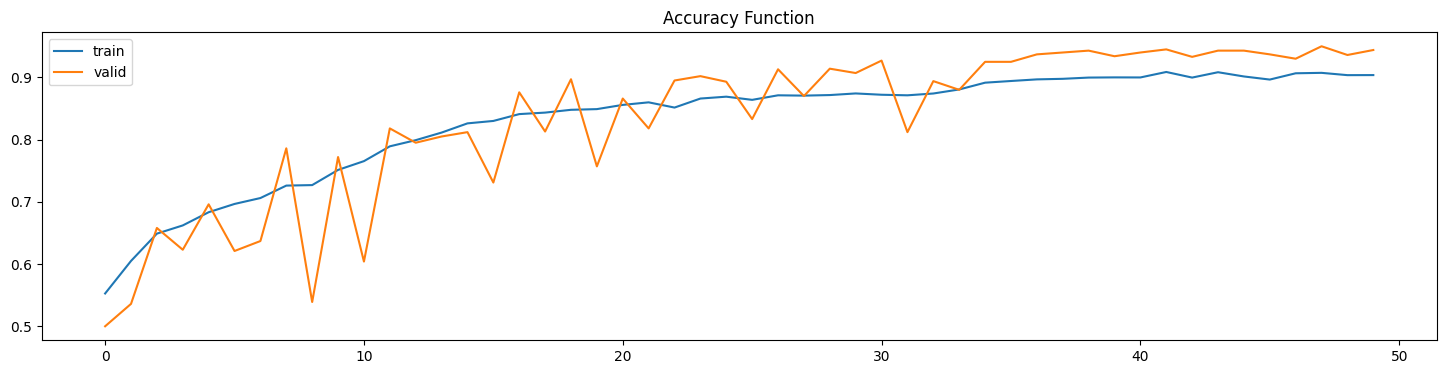

In [31]:
import pandas as pd

# Load training history
history_df = pd.read_csv('/content/training_history_cnn.csv')


plt.figure(figsize=(18, 4))
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'valid')
plt.legend()
plt.title('Accuracy Function')
plt.show()

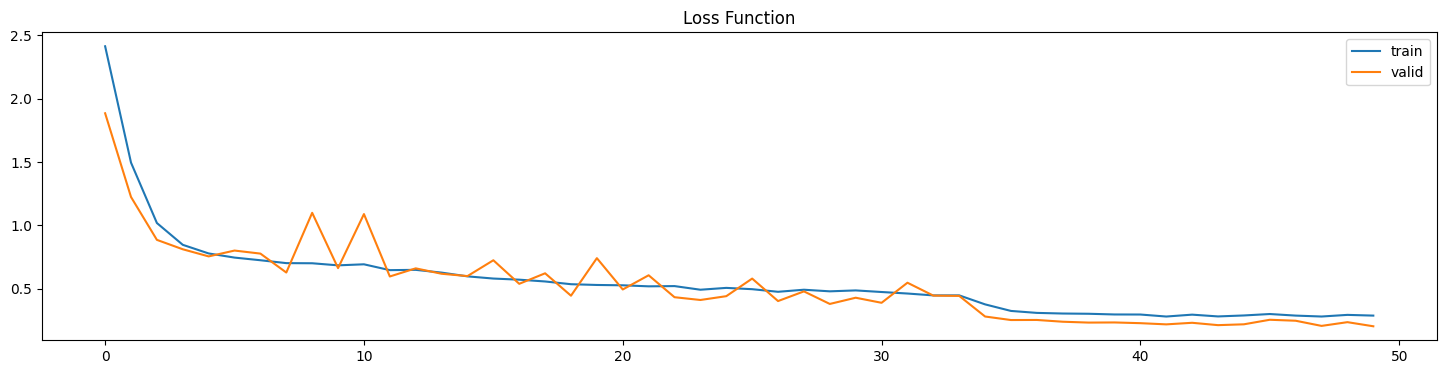

In [32]:
plt.figure(figsize=(18, 4))
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'valid')
plt.legend()
plt.title('Loss Function')
plt.show()

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 216, 176, 16)      448       
                                                                 
 batch_normalization (Batch  (None, 216, 176, 16)      64        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 108, 88, 16)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 106, 86, 32)       4640      
                                                                 
 batch_normalization_1 (Bat  (None, 106, 86, 32)       128       
 chNormalization)                                                
                                                        

In [34]:
!pip install graphviz pydot

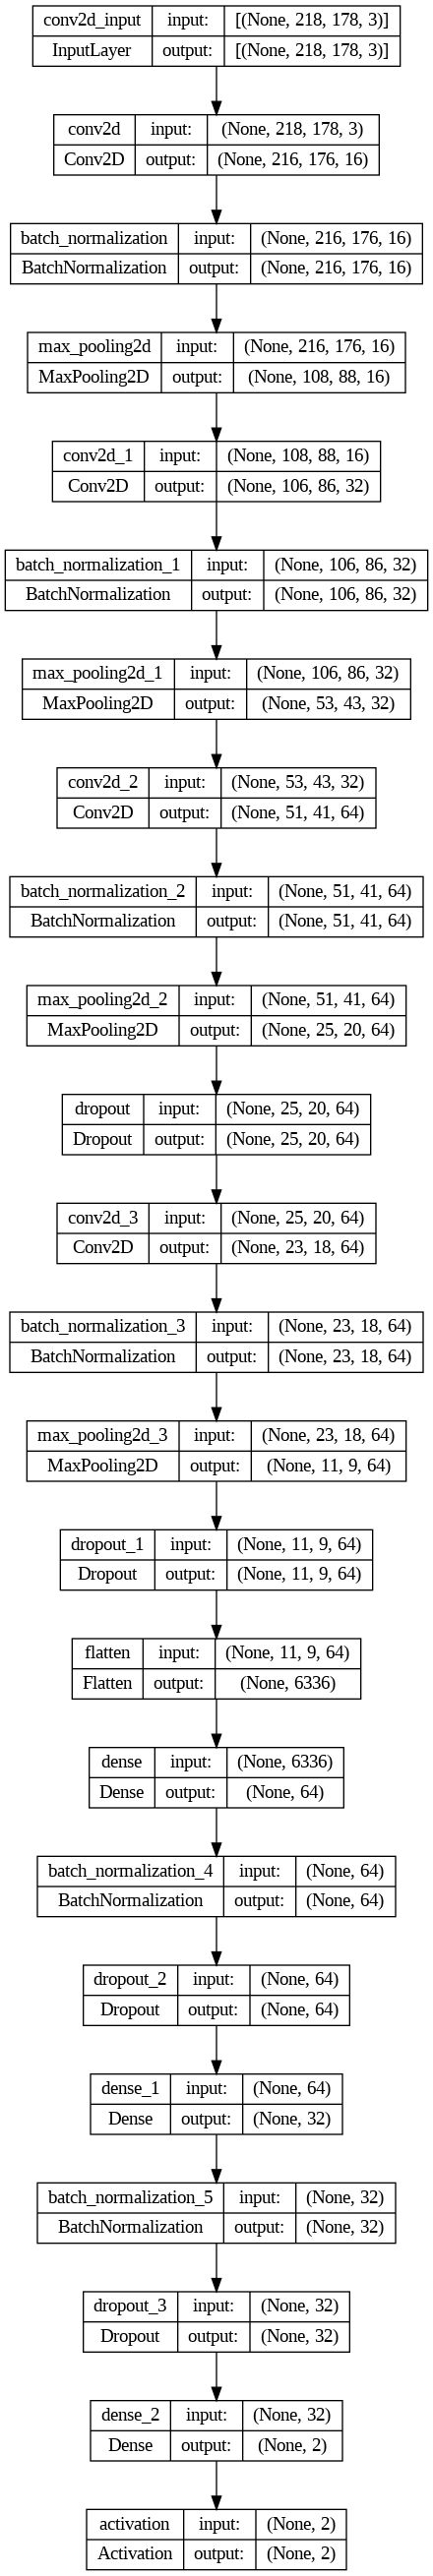

In [35]:
from tensorflow.keras.utils import plot_model

# Plot model architecture
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

# Display the plot in the notebook
from IPython.display import Image
Image(filename='model_architecture.png')

32/32 [==============================] - 1s 17ms/step
Accuracy: 93.7000%
F1 score: 0.9370


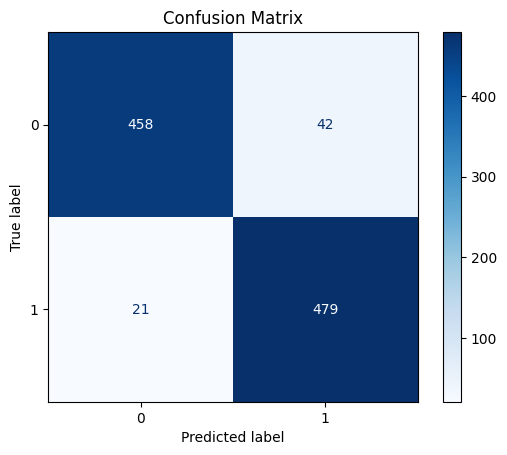

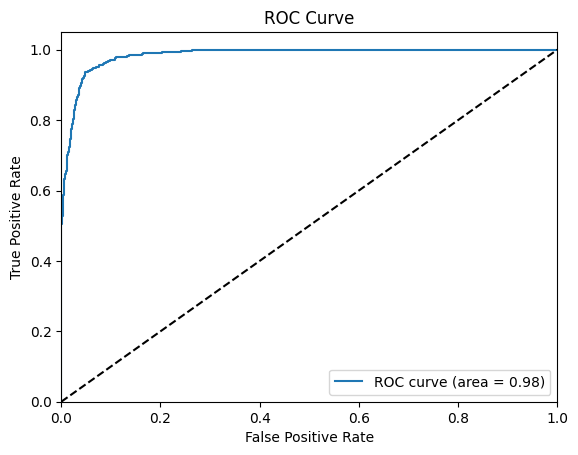

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_curve, auc, ConfusionMatrixDisplay, RocCurveDisplay
from tensorflow.keras.models import load_model

# Model Evaluation
x_test_reshaped = x_test.reshape((-1, 218, 178, 3))

# Load model
model = load_model('best_custom_cnn.h5')

# Predict using the whole array
predictions = model.predict(x_test_reshaped)
predicted_classes = np.argmax(predictions, axis=1)

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_test, predicted_classes)
f1 = f1_score(y_test, predicted_classes, average='weighted')

print('Accuracy: {:.4f}%'.format(accuracy * 100))
print('F1 score: {:.4f}'.format(f1))

# Confusion Matrix
cm = confusion_matrix(y_test, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# ROC Curve and AUC
# Assuming binary classification (Female=0, Male=1)
y_test_binary = (y_test == 1).astype(int)
predictions_binary = predictions[:, 1]

fpr, tpr, _ = roc_curve(y_test_binary, predictions_binary)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

Loaded image: /content/img_align_celeba/img_align_celeba/191792.jpg
Preprocessed image shape: (1, 218, 178, 3)
1/1 [==============================] - 0s 347ms/step


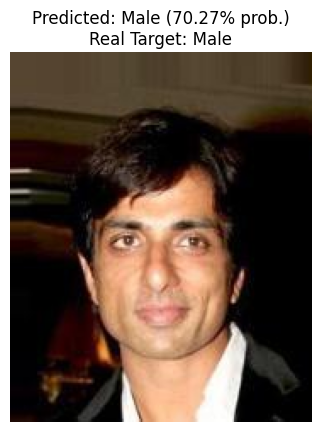

Loaded image: /content/img_align_celeba/img_align_celeba/194930.jpg
Preprocessed image shape: (1, 218, 178, 3)
1/1 [==============================] - 0s 70ms/step


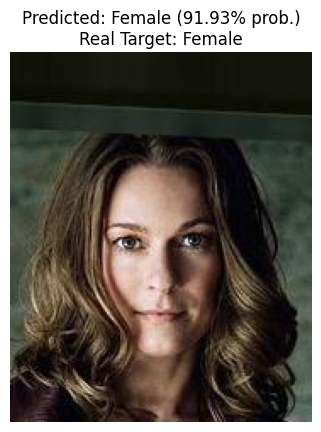

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import load_model

# Assuming you have a DataFrame df_par_attr with image paths and gender labels
# and a function gender_prediction that takes an image path and returns the prediction

# Define the gender prediction function
def gender_prediction(image_path):
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image not found or unable to read: {image_path}")

    print(f"Loaded image: {image_path}")

    # Resize the image to match the model input size
    try:
        image = cv2.resize(image, (178, 218))  # Resize to the input size of the model
    except Exception as e:
        raise ValueError(f"Error resizing image: {e}")

    # Normalize the image if the model requires it
    image = image.astype('float32') / 255.0  # Assuming the model expects normalized input
    image = np.expand_dims(image, axis=0)  # Add batch dimension

    print(f"Preprocessed image shape: {image.shape}")

    # Predict the gender
    prediction = model.predict(image)
    predicted_class = np.argmax(prediction, axis=1)[0]
    class_label = 'Female' if predicted_class == 0 else 'Male'
    probability = np.max(prediction) * 100

    #print(f"Prediction: {prediction}, Predicted class: {class_label}, Probability: {probability:.2f}%")
    return class_label, probability

# Define the display result function
def display_result(image_path, prediction, true_label):
    image = cv2.imread(image_path)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f'Predicted: {prediction[0]} ({prediction[1]:.2f}% prob.)\nReal Target: {true_label}')
    plt.show()

# Load the model
model = load_model('best_custom_cnn.h5')

# Select random images from the test partition
df_to_test = df[(df['partition'] == 2)].sample(2)

# Define the image folder
images_folder = '/content/img_align_celeba/img_align_celeba/'

# Predict and display results
for index, target in df_to_test.iterrows():
    image_path = images_folder + index
    result = gender_prediction(image_path)
    true_label = 'Male' if target['Male'] == 1 else 'Female'
    display_result(image_path, result, true_label)